In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

SEED = 383561
np.random.seed(SEED) # from random.org, for reproducibility


# The Model 

In [2]:
import theano.tensor as tt
from pymc3.distributions.dist_math import gammaln, bound, factln

class DirichletMultinomial(pm.Discrete):
    def __init__(self, n, a, *args, **kwargs):
        super(DirichletMultinomial, self).__init__(*args, **kwargs)

        self.K = tt.as_tensor_variable(a.shape[-1])
        self.n = tt.as_tensor_variable(n[:, np.newaxis])

        if a.ndim == 1:
            self.alphas = tt.as_tensor_variable(a[np.newaxis, :])  # alphas[1, #classes]
        else:
            self.alphas = tt.as_tensor_variable(a)  # alphas[#samples, #classes]

        self.A = self.alphas.sum(axis=-1, keepdims=True)  # A[#samples]
        self.mean = self.n * (self.alphas / self.A)

        self.mode = tt.cast(pm.math.tround(self.mean), 'int32')

    def logp(self, value):
        printing = False
        k = self.K
        a = self.alphas
        A = self.A
        n = self.n
        res = bound(tt.squeeze(factln(n) + gammaln(A) - gammaln(A + n) +
                               tt.sum(gammaln(a + value) - gammaln(a) - factln(value), keepdims=True, axis=-1)),
                    tt.all(value >= 0),
                    tt.all(tt.eq(tt.sum(value, axis=-1, keepdims=True), n)),
                    tt.all(a > 0),
                    k > 1,
                    tt.all(tt.ge(n, 0)),
                    broadcast_conditions=False
                    )
        return res

In [5]:
def generate_spike_and_slab_model(n_total, X, data):
    n,k = X.shape
    m = data.shape[1]
    
    with pm.Model() as spike_and_slab_non_centered:
        
        #random effect
        packed_L = pm.LKJCholeskyCov('packed_L', n=m,
                                     eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
        L = pm.expand_packed_triangular(m, packed_L)

        #intercept
        sigma_alpha = pm.HalfCauchy("sigma_alpha", 5)
        #mu_alpha = pm.Normal("mu_alpha", mu=0, sd=100**2)
        alpha_offset = pm.Normal("alpha_offset", 0,1, shape=m)
        alpha = pm.Deterministic("alpha", 0. + alpha_offset*sigma_alpha)

        #fixed effect
        omega = pm.Beta("omega", 1, 1)
        pi = pm.Bernoulli("pi", omega, shape=(k,m))


        sigma_beta = pm.HalfCauchy("sigma_beta", 5)
        #mu_beta = pm.Normal("mu_beta", mu=0, sd=100**2)
        beta_offset = pm.Normal("beta_offset", 0, 1, shape=(k,m))
        beta_raw = pm.Deterministic("beta_raw", 0.+sigma_beta*beta_offset)


        log_gamma = pm.MvNormal("log_gamma", alpha + pm.math.dot(X, pi*beta_raw), chol=L, shape=(n,m))
        #log_gamma = alpha + pm.math.dot(X, pi*beta_raw) + V
        F1 = DirichletMultinomial('likelihood', n_total, 
                                  pm.math.exp(log_gamma), 
                                  observed = data)
    return spike_and_slab_non_centered


def generate_spike_and_slab_model_concrete(n_total, X, data):
    n,k = X.shape
    m = data.shape[1]
    
    with pm.Model() as spike_and_slab_non_centered:
        
        #random effect
        packed_L = pm.LKJCholeskyCov('packed_L', n=m,
                                     eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
        L = pm.expand_packed_triangular(m, packed_L)

        #intercept
        sigma_alpha = pm.HalfCauchy("sigma_alpha", 5)
        mu_alpha = pm.Normal("mu_alpha", mu=0, sd=100**2)
        alpha_offset = pm.Normal("alpha_offset", 0,1, shape=m)
        alpha = pm.Deterministic("alpha", mu_alpha + alpha_offset*sigma_alpha)

        #fixed effect
        #shape=(k,m)
        omega = pm.Beta("omega", 1, 1)
        pi = pm.Bernoulli("pi", omega, shape=(k,m))


        sigma_beta = pm.HalfCauchy("sigma_beta", 5)
        mu_beta = pm.Normal("mu_beta", mu=0, sd=100**2)
        beta_offset = pm.Normal("beta_offset", 0, 1, shape=(k,m))
        beta_raw = pm.Deterministic("beta_raw", mu_beta+sigma_beta*beta_offset)


        gamma = pm.MvNormal("log_gamma", alpha + pm.math.dot(X, pi*beta_raw), chol=L, shape=(n,m))
        #log_gamma = alpha + pm.math.dot(X, pi*beta_raw) + V
        F1 = pm.Multinomial('likelihood', n_total, 
                                   tt.nnet.softmax(gamma),
                                  observed = data)
    return spike_and_slab_non_centered


def generate_regression_model(n_total, X, data):
    n,k = X.shape
    m = data.shape[1]
    
    with pm.Model() as spike_and_slab_non_centered:
        
        #random effect
        packed_L = pm.LKJCholeskyCov('packed_L', n=m,
                                     eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
        L = pm.expand_packed_triangular(m, packed_L)

        #intercept
        sigma_alpha = pm.HalfCauchy("sigma_alpha", 5)
        alpha_offset = pm.Normal("alpha_offset", 0,1, shape=m)
        alpha = pm.Deterministic("alpha", alpha_offset*sigma_alpha)


        sigma_beta = pm.HalfCauchy("sigma_beta", 5)
        beta_offset = pm.Normal("beta_offset", 0, 1, shape=(k,m))
        beta_raw = pm.Deterministic("beta_raw", sigma_beta*beta_offset)

        log_gamma = pm.MvNormal("log_gamma", alpha + pm.math.dot(X, beta_raw), chol=L, shape=(n,m))
        #log_gamma = alpha + pm.math.dot(X, pi*beta_raw) + V
        F1 = DirichletMultinomial('likelihood', n_total, 
                                  pm.math.exp(log_gamma), 
                                  observed = data)
    return spike_and_slab_non_centered



def generate_regression_model(n_total, X, data):
    n,k = X.shape
    m = data.shape[1]
    
    with pm.Model() as spike_and_slab_non_centered:
        
        #random effect
        packed_L = pm.LKJCholeskyCov('packed_L', n=m,
                                     eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
        L = pm.expand_packed_triangular(m, packed_L)

        #intercept
        sigma_alpha = pm.HalfCauchy("sigma_alpha", 5)
        alpha_offset = pm.Normal("alpha_offset", 0,1, shape=m)
        alpha = pm.Deterministic("alpha", alpha_offset*sigma_alpha)


        sigma_beta = pm.HalfCauchy("sigma_beta", 5)
        beta_offset = pm.Normal("beta_offset", 0, 1, shape=(k,m))
        beta_raw = pm.Deterministic("beta_raw", sigma_beta*beta_offset)

        log_gamma = pm.MvNormal("log_gamma", alpha + pm.math.dot(X, beta_raw), chol=L, shape=(n,m))
        #log_gamma = alpha + pm.math.dot(X, pi*beta_raw) + V
        F1 = DirichletMultinomial('likelihood', n_total, 
                                  pm.math.exp(log_gamma), 
                                  observed = data)
    return spike_and_slab_non_centered

# Uncorrelated Simulation Study


In [7]:
#n = 20 # number of samples
#m = 10  # number of populations 
#k = 3  # number of covariats

#m_r = 5 number of effected populations
#k_r = 2 number of non-zero covariats

def generate_data(n=20, m=10, k=3, m_r=5, k_r=2,rho=0.4):

    # Covaraits drawn from MvNormal(0, Cov) Cov_ij = p ^|i-j| , p=0.4
    #Tibshirani for correlated covariats Tibshirani (1996) 
    #X_cov =np.array([[rho**np.abs(i-j) for j in range(k)] for i in range(k)])
    X_cov = np.eye(k)
    X = np.random.multivariate_normal(np.zeros(k), cov=X_cov, size=n)
    print(X.shape)
    m_r_idx = np.random.choice(range(m), size=m_r, replace=False)
    k_r_idx = np.random.choice(range(k), size=k_r, replace=False)

    # slope and intercepts
    alphas = np.random.uniform(-2.3, 2.3, size=m)
    betas = np.zeros((k,m))

    for i in k_r_idx:
        for j in m_r_idx:
            #p = np.random.binomial(n=1, p= 0.5)
            betas[i,j] = 2. 
    
    xi = 0.01 #dispersion parameter
    gamma_raw = np.exp(alphas + np.matmul(X, betas))
    gamma_plus = gamma_raw.sum(axis=1)
    gamma = (gamma_raw/gamma_plus[:, None]) *((1-xi)/xi)
    
    y = np.zeros((n, m))
    
    # sample total number of reads:
    n_total = np.random.randint(20000, 50000, size=n)
    
    for i in range(n):
        pi = np.random.dirichlet(gamma[i,:])
        y[i,:] = np.random.multinomial(n_total[i], pi)
    
    return n_total,X,y,m_r_idx, k_r_idx
    
    
def calc_statistics(beta_true, m_r_idx, k_r_idx):
    """
    calculates TPR and FTR AUC MCC etc.
    """
    
    
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)


    
def run_uncorrelated_simulation(N=1):
    n=10 
    m=5
    k=3 
    m_r=1 
    k_r=2
    
    
    for h in range(N):
        n_total, X_data,y_data, m_r_idx, k_r_idx = generate_data(n,m,k,m_r,k_r)
        #model = generate_regression_model(n_total, X_data, y_data)
        #model = generate_spike_and_slab_model(n_total, X_data, y_data)
        model = generate_spike_and_slab_model_concrete(n_total, X_data, y_data)
        
        
        print(n_total)
        print()
        print(X_data)
        print()
        print(y_data)
        print(k_r_idx, m_r_idx)
        
        with model:
            trace = pm.sample(1000,
                         random_seed=SEED, 
                         cores=4, 
                         tune=500, 
                         chains=2, 
                         tree_depth=20, 
                         target_accept=0.90,
                       )
        return trace
    
trace = run_uncorrelated_simulation()




(10, 3)
[32629 40393 49747 35722 47687 21102 43010 25205 43060 35965]

[[ 1.1397216  -0.00950802 -1.06553178]
 [ 1.51946953 -1.2187657  -2.3992552 ]
 [ 1.26655671 -0.43003431 -1.49344302]
 [ 1.71227047  0.42555649 -1.28118525]
 [-0.79396112 -0.72220295 -0.68802496]
 [ 0.39601566 -1.3126058  -0.01982064]
 [ 0.40668238  0.52099091  1.05931253]
 [-1.147286    0.46148487 -1.72861959]
 [ 0.50966316  1.09687878  1.40117448]
 [-0.87459514  0.28670327 -0.3890497 ]]

[[2.7940e+04 2.0000e+03 3.2400e+02 7.0800e+02 1.6570e+03]
 [3.4700e+04 4.1680e+03 3.2100e+02 1.0100e+03 1.9400e+02]
 [4.2576e+04 3.3910e+03 8.6100e+02 1.6200e+03 1.2990e+03]
 [2.8849e+04 2.7920e+03 1.1150e+03 4.3200e+02 2.5340e+03]
 [4.2471e+04 3.9960e+03 2.1800e+02 9.3900e+02 6.3000e+01]
 [1.8914e+04 7.8100e+02 2.1800e+02 8.2000e+01 1.1070e+03]
 [2.0377e+04 2.6120e+03 5.0700e+02 3.7200e+02 1.9142e+04]
 [2.0834e+04 2.9110e+03 5.0600e+02 9.5400e+02 0.0000e+00]
 [1.2785e+04 1.5150e+03 4.1400e+02 7.6000e+01 2.8270e+04]
 [3.1267e+04 3.

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [log_gamma, beta_offset, sigma_beta, omega, alpha_offset, sigma_alpha, packed_L]
>BinaryGibbsMetropolis: [pi]
Sampling 2 chains:   6%|▋         | 442/7000 [02:20<10:58:15,  6.02s/draws]


ValueError: Not enough samples to build a trace.

In [102]:
pm.summary(trace, varnames=["pi"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
pi__0_0,0.58600,0.492548,0.045032,0.0,1.0,13.529725,1.102707
pi__0_1,0.55800,0.496625,0.043043,0.0,1.0,18.370864,1.061713
pi__0_2,0.51250,0.499844,0.030701,0.0,1.0,52.355022,1.027025
pi__0_3,0.60975,0.487806,0.037483,0.0,1.0,19.964289,1.060732
pi__0_4,0.45525,0.497993,0.021873,0.0,1.0,220.151489,1.013201
pi__1_0,0.30700,0.461249,0.034123,0.0,1.0,67.673800,1.075104
pi__1_1,0.26100,0.439180,0.034363,0.0,1.0,57.014985,1.086764
pi__1_2,0.43400,0.495625,0.027451,0.0,1.0,46.193164,1.038447
pi__1_3,0.45575,0.498038,0.027301,0.0,1.0,84.867572,1.008833
pi__1_4,0.56575,0.495658,0.026277,0.0,1.0,82.306707,1.016723


/home/benjamin/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


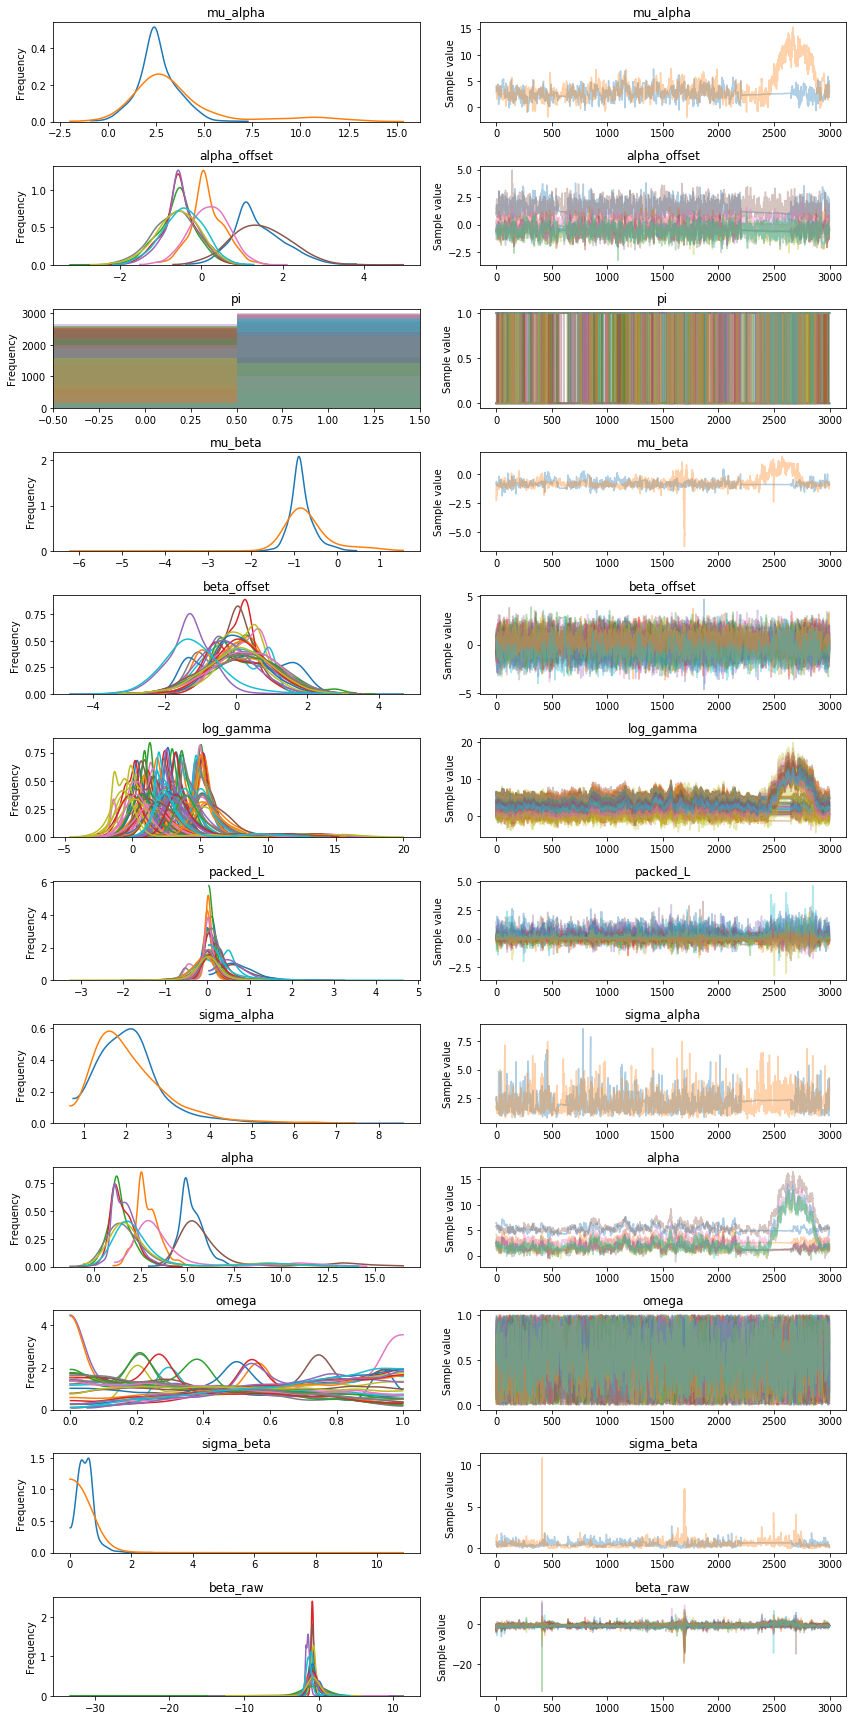

In [87]:
t = pm.traceplot(trace)

Species=0, Covariat=0 = P(inclusion)=0.4970193
Species=0, Covariat=1 = P(inclusion)=0.4753963
Species=0, Covariat=2 = P(inclusion)=0.4842843
Species=1, Covariat=0 = P(inclusion)=0.4599663
Species=1, Covariat=1 = P(inclusion)=0.4887403
Species=1, Covariat=2 = P(inclusion)=0.4875943
Species=2, Covariat=0 = P(inclusion)=0.4698573
Species=2, Covariat=1 = P(inclusion)=0.4928493
Species=2, Covariat=2 = P(inclusion)=0.4953733
Species=3, Covariat=0 = P(inclusion)=0.4571563
Species=3, Covariat=1 = P(inclusion)=0.4504183
Species=3, Covariat=2 = P(inclusion)=0.4804183
Species=4, Covariat=0 = P(inclusion)=0.1765663
Species=4, Covariat=1 = P(inclusion)=0.4947023
Species=4, Covariat=2 = P(inclusion)=0.2741843


In [ ]:
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()